In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from multiprocessing import Pool
import random
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
## Dataset

In [3]:
fpath = 'family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = 'sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [4]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [5]:
data.n_people.sum()

21003

In [6]:
submission.head()

,assigned_day
family_id,
0,100
1,99
2,98
3,97
4,96


In [7]:
submission.shape

(5000, 1)

In [8]:
## Loss Function

In [9]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].T.to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

In [10]:
family_size_ls = list(family_size_dict.values())
choice_dict_num = [{vv:i for i, vv in enumerate(di.values())} for di in choice_dict.values()]

# Computer penalities in a list
penalties_dict = {
    n: [
        0,
        50,
        50 + 9 * n,
        100 + 9 * n,
        200 + 9 * n,
        200 + 18 * n,
        300 + 18 * n,
        300 + 36 * n,
        400 + 36 * n,
        500 + 36 * n + 199 * n,
        500 + 36 * n + 398 * n
    ]
    for n in range(max(family_size_dict.values())+1)
} 

In [11]:
choice_dict_num[0]

{52: 0, 38: 1, 12: 2, 82: 3, 33: 4, 75: 5, 64: 6, 76: 7, 10: 8, 28: 9}

In [133]:
def cost_function(prediction):
    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day, n is size of that family, 
    # and choice is their top choices
    for n, c, c_dict, choice in zip(family_size_ls, prediction, list(choice_dict.values()), choice_dict_num):
        
        # Day
        if c == 10:
            d = randint(0, 100) + 1
        else:
            d = c_dict['choice_{}'.format(c)]
        
        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d not in choice:
            penalty += penalties_dict[n][-1]
        else:
            penalty += penalties_dict[n][choice[d]]

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    k = 0
    for v in daily_occupancy.values():
        if (v > MAX_OCCUPANCY):
            k = k + (v - MAX_OCCUPANCY)
        if (v < MIN_OCCUPANCY):
            k = k + (MIN_OCCUPANCY - v)
    #    if k > 0:
    #        penalty += 100000000 
    penalty += penalty*(k/21003)

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return penalty

In [134]:
def is_constraint(prediction):
    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day, n is size of that family, 
    # and choice is their top choices
    for n, d, choice in zip(family_size_ls, prediction, choice_dict_num):
        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for v in daily_occupancy.values():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            return True
    return False

In [135]:
from numpy.random import randint

solution = randint(0, 11, 5000)
print(solution)
print(cost_function(solution))

[ 4  8  3 ...  2 10  3]
7.976944822968984e+61


In [136]:
# # Start with the sample submission values
# best  = submission['assigned_day'].tolist()
# score = cost_function(best)
# score

In [137]:
# # Start with the sample submission values
# best  = submission['assigned_day'].tolist()
# score = cost_function(best)
# score

## Genetic Algorithm (GA)

## Genetic Algorithm

Basic Description
Genetic algorithms are inspired by Darwin's theory about evolution. Solution to a problem solved by genetic algorithms is evolved.

Algorithm is started with a set of solutions (represented by chromosomes) called population. Solutions from one population are taken and used to form a new population. This is motivated by a hope, that the new population will be better than the old one. Solutions which are selected to form new solutions (offspring) are selected according to their fitness - the more suitable they are the more chances they have to reproduce.

Outline of the Basic Genetic Algorithm
* **[Start]** Generate random population of n chromosomes (suitable solutions for the problem)
* **[Fitness]** Evaluate the fitness f(x) of each chromosome x in the population
    * **[New population]** Create a new population by repeating following steps until the new population is complete
    * **[Selection]** Select two parent chromosomes from a population according to their fitness (the better fitness, the bigger chance to be selected)
    * **[Crossover]** With a crossover probability cross over the parents to form a new offspring (children). If no crossover was performed, offspring is an exact copy of parents.
    * **[Mutation]** With a mutation probability mutate new offspring at each locus (position in chromosome).
    * [Accepting] Place new offspring in a new population
* **[Replace]** Use new generated population for a further run of algorithm
* **[Test]** If the end condition is satisfied, stop, and return the best solution in current population
* **[Loop]** Go to step 2

http://www.obitko.com/tutorials/genetic-algorithms/ga-basic-description.php


In [138]:
from tqdm import tqdm
from itertools import starmap



"""Genetic Algorithmn Implementation
see:
http://www.obitko.com/tutorials/genetic-algorithms/ga-basic-description.php
"""
class GeneticAlgorithm(object):
    def __init__(self, genetics):
        self.genetics       = genetics
        self.best_solution  = None
        self.avg_fitness    = []
        self.best_fitness   = []
        pass

    def fitness(self, ch):
        return (self.genetics.fitness(ch),  ch)
    
    def run(self, processes=4):
        population = self.genetics.initial()
        pool       = Pool(processes=processes)
        
        while True:
            #fits_pops = [self.fitness(ch) for ch in population]
            fits_pops = pool.map(self.fitness, population)
            #fits_pops = list(tqdm(starmap(self.fitness, population), total=len(population)))
            
            fits_pops = list(sorted(fits_pops))
            
            # Log
            self.avg_fitness.append(np.median([f for f, ch in fits_pops]))
            self.best_fitness.append(np.min([f for f, ch in fits_pops]))

            self.best_solution = fits_pops[0][1]
            
            if self.genetics.check_stop(fits_pops): 
                break
            
            population = self.next(fits_pops)
            population.append(self.best_solution.copy())
            pass
        return population

    def next(self, fits):
        parents_generator = self.genetics.parents(fits)
        size  = len(fits)
        nexts = [self.best_solution.copy()]
        while len(nexts) < size:
            parents  = next(parents_generator)
            cross    = random.random() < self.genetics.probability_crossover()
            children = self.genetics.crossover(parents) if cross else parents

            for ch in children:
                mutate = random.random() < self.genetics.probability_mutation()
                nexts.append(self.genetics.mutation(ch) if mutate else ch)
                pass
            pass
        return nexts[0:size]
    pass

#### Genetic Algorithms: ...


In [139]:
class SantasWorkshop():
    def __init__(self, generation=10, size=5,
                 prob_crossover=0.9, prob_mutation=0.2,
                mutation_size = 0.1):
        self.counter   = 0
        
        self.generation = generation
        self.size  = size        
        self.prob_crossover = prob_crossover
        self.prob_mutation  = prob_mutation
        self.mutation_size  = mutation_size

    # GeneticFunctions interface impls
    def probability_crossover(self):
        return self.prob_crossover

    def probability_mutation(self):
        return self.prob_mutation

    # Initial population based in s0
    def initial(self):
        population = [self.random_chromo() for j in range(self.size)]
        return population

    def fitness(self, chromo):
        score = cost_function(chromo)
        return score

    def check_stop(self, fits_populations):
        self.counter += 1
        
        if self.counter % 2 == 0:

            fits  = [f for f, ch in fits_populations]
            best  = min(fits)
            worst = max(fits)
            ave   = sum(fits) / len(fits)
            print(
                "[G %3d] score=(%2f, %2f, %2f, %2f): %r" %
                (self.counter, best, ave, worst, len(fits), []))
            pass

        return self.counter >= self.generation

    def parents(self, fits_populations):
        while True:
            father = self.tournament(fits_populations)
            mother = self.tournament(fits_populations)
            yield (father, mother)
            pass
        pass

    def crossover(self, parents):
        ind1, ind2 = parents
        
        size = min(len(ind1), len(ind2))
        a, b = random.sample(range(size), 2)
        if a > b:
            a, b = b, a

        holes1, holes2 = [True]*size, [True]*size
        for i in range(size):
            if i < a or i > b:
                holes1[ind2[i]-1] = False
                holes2[ind1[i]-1] = False

        # We must keep the original values somewhere before scrambling everything
        temp1, temp2 = ind1, ind2
        k1 , k2 = b + 1, b + 1
        for i in range(size):
            if not holes1[temp1[(i + b + 1) % size]-1]:
                ind1[k1 % size] = temp1[(i + b + 1) % size]
                k1 += 1

            if not holes2[temp2[(i + b + 1) % size]-1]:
                ind2[k2 % size] = temp2[(i + b + 1) % size]
                k2 += 1

        # Swap the content between a and b (included)
        for i in range(a, b + 1):
            ind1[i], ind2[i] = ind2[i], ind1[i]

        return ind1, ind2

    def mutation(self, chromosome):
        mutated = chromosome
        
        for k in range(int(len(chromosome)*self.mutation_size)):
            i = random.randint(0, len(chromosome)-1)
            mutated[i] = randint(0,11)

        return mutated

    def tournament(self, fits_populations):
        alicef, alice = self.select_random(fits_populations)
        bobf, bob = self.select_random(fits_populations)
        return alice if alicef < bobf else bob

    def select_random(self, fits_populations):
        return fits_populations[random.randint(0, len(fits_populations)-1)]

    def random_chromo(self):
        #chromo = [random.choice(data.loc[i].values[:-1]) for i in range(len(df))]
        chromo = list(randint(0, 11, 5000))

        #chromo = list(df.assigned_day.sample(frac=1).values)
        return chromo
    pass

In [140]:
randint(0, 10, 100)

array([0, 1, 4, 7, 0, 0, 9, 9, 8, 7, 9, 2, 8, 5, 2, 8, 3, 6, 4, 7, 8, 5,
       6, 6, 6, 4, 7, 6, 6, 9, 4, 2, 8, 9, 2, 5, 5, 4, 2, 6, 0, 2, 1, 5,
       3, 9, 5, 8, 4, 6, 7, 3, 7, 3, 2, 5, 5, 0, 4, 7, 0, 0, 9, 7, 9, 6,
       1, 8, 9, 9, 4, 6, 1, 7, 1, 2, 6, 6, 6, 5, 4, 3, 1, 7, 3, 4, 7, 3,
       1, 2, 6, 8, 8, 0, 3, 7, 4, 0, 7, 7])

## Compute GA

In [141]:
#%%time

import gc
gc.collect()
#df = submission#['assigned_day']

generation      = 300
population_size = 1000
prob_crossover  = 0.9
prob_mutation   = 0.1

ga = GeneticAlgorithm(
    SantasWorkshop(generation=generation, size=population_size, 
                   prob_crossover=prob_crossover, prob_mutation=prob_mutation)
)

#da = SantasWorkshop(generation=generation, size=population_size, 
#                   prob_crossover=prob_crossover, prob_mutation=prob_mutation)
#da.initial()
best_solution = ga.run()

[G   2] score=(929743730841768688583223021254415693138781798400.000000, 65653096995519368214559664113734479770060750198762481994005054440341504.000000, 32941627160396690052347549007042446018692563486246706012611320323061579776.000000, 1001.000000): []
[G   4] score=(226050035833075968528502429154754092898885566464.000000, 2524081890033731329547790095842565515381191501608951594673200387063808.000000, 2391314990639844749294227474055584906253538873233789276434643205100666880.000000, 1003.000000): []
[G   6] score=(19307532203602428348425680031628455028195328.000000, 36047136203728161919341324036882203040359696786970229113635209216.000000, 18441258553581849803759129405940118827692619627778478025414170116096.000000, 1005.000000): []
[G   8] score=(709998930507138025498656849511878450216960.000000, 8261974486871463271030765636935341280752957140533977389465600.000000, 3577267969498242824191308858036882629291674689317771684387749888.000000, 1007.000000): []
[G  10] score=(365044695194563059938

[G 108] score=(145986158967159360.000000, 324568436379003243787714560.000000, 233299765494159306103101325312.000000, 1107.000000): []
[G 110] score=(295043508896364096.000000, 1196414104282032277986941916628145315172954440699031322624.000000, 856861731764574625339485428837888297681505557149882668548096.000000, 1109.000000): []
[G 112] score=(81897908781980960.000000, 45774814992943305676958990336.000000, 38137051399052586109410448769024.000000, 1111.000000): []
[G 114] score=(53530939023373312.000000, 217927408086304372513832960.000000, 60310776332642511923686932480.000000, 1113.000000): []
[G 116] score=(71963966563924904.000000, 446001914669718236200697856.000000, 472922386876673794761161703424.000000, 1115.000000): []
[G 118] score=(214560173564969440.000000, 1427310860199835712807239680.000000, 1191612862704949958529299513344.000000, 1117.000000): []
[G 120] score=(146513414529612416.000000, 9472872996029655123230720.000000, 4656141003493715395144056832.000000, 1119.000000): []
[G 

[G 232] score=(3309571101796525.000000, 20999715549440185957613568.000000, 22775215548987178516377239552.000000, 1231.000000): []
[G 234] score=(2902660726454001.000000, 15264109002211221875720192.000000, 6101649171635281531334819840.000000, 1233.000000): []
[G 236] score=(1858852025131531.250000, 13166338758013787138162688.000000, 15322590977963363367754137600.000000, 1235.000000): []
[G 238] score=(7319883180821467.000000, 2343625201690382346557140547445064728576.000000, 2408371441659594881066061223333521625448448.000000, 1237.000000): []
[G 240] score=(3085911497631961.000000, 3370111784046211792633856.000000, 3071082987914385042316460032.000000, 1239.000000): []
[G 242] score=(4123750307362908.000000, 12122009914855385437283811328.000000, 7252741684557088459278816116736.000000, 1241.000000): []
[G 244] score=(2107940792654379.750000, 943754322676779512233984.000000, 212847496773141249587675136.000000, 1243.000000): []
[G 246] score=(5055515149650414.000000, 152225796863991500872089

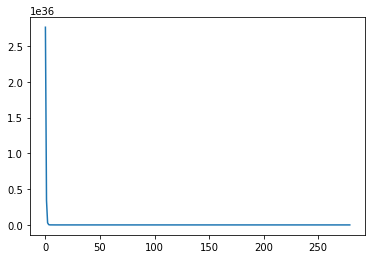

In [147]:
#plt.plot(ga.avg_fitness)
t = 20
sns.lineplot(y=ga.avg_fitness[t:], x=range(len(ga.avg_fitness[t:])))

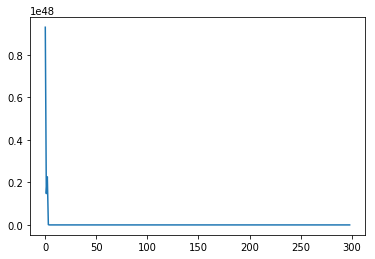

In [148]:
#plt.plot(ga.avg_fitness)
t = 1
sns.lineplot(y=ga.best_fitness[t:], x=range(len(ga.best_fitness[t:])))

In [149]:
# g = SantasWorkshop(df, data, generation=generation, size=population_size, 
#                    prob_crossover=prob_crossover, prob_mutation=prob_mutation)

# chromo = g.random_chromo()
# cost_function(chromo)

In [150]:
best_solution =  ga.best_solution
cost_function(best_solution)


days = []
for n, c, c_dict in zip(family_size_ls, best_solution, list(choice_dict.values())):
    days.append(c_dict['choice_{}'.format(c)])
days

KeyError: 31

In [151]:
submission['assigned_day']=days
submission.to_csv('submission.csv')

ValueError: Length of values does not match length of index